In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# EMNIST
# We use the dataset that contains handwriting character from a to h
# Each character has 128 image as data
# The data is load from the folder 'EMNIST'

In [4]:
# first step is to load data for training and test

In [5]:
# Load EMNIST image
def Load_EMNIST(test_index, algorithm):
    # define information about EMNIST dataset
    number = 128
    classes = 8
    character_list = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

    # load the whole dataset
    x_total = []
    y_total = []
    for i, c in enumerate(character_list):
        for j in range(number):
            #x_total.append(cv2.imread('./EMNIST/'+c+'/'+str(j)+'.jpg'))
            x_total.append(cv2.imread('/content/drive/MyDrive/Colab Notebooks/AI/EMNIST/' + c + '/'+str(j) + '.jpg'))
            y_total.append(i)
    
    # seperate dataset into training and test set
    # initialize as any array
    x_train, y_train, x_test, y_test = [], [], [], []
    
    # if we're not applying CNN, then flatten the image into 1D array
    if algorithm == 0:
        x_flatten = []
        for i in range(len(x_total)):
            x_flatten.append(x_total[i].flatten())
        x_train, y_train, x_test, y_test = Seperate_Dataset(x_flatten, y_total, test_index, number, classes)
    # CNN use 2D image
    elif algorithm == 1: 
        x_train, y_train, x_test, y_test = Seperate_Dataset(x_total, y_total, test_index, number, classes)
    
    # convert list to ndarray
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    # normalize image by dividing 255
    x_train = x_train / 255.0
    x_test = x_test / 255.0
    
    # one-hot encoding for label
    y_train = One_hot_encoding(y_train, classes)
    y_test = One_hot_encoding(y_test, classes)
    
    return x_train, y_train, x_test, y_test

In [6]:
# seperate dataset into training set and test set
def Seperate_Dataset(x_total, y_total, test_index, number, classes):
    x_train = []
    y_train_temp = []
    x_test = []
    y_test_temp = []
    
    # seperate dataset
    for i in range(classes):
        character_type = 128 * i
        for j in range(number):
            index = character_type + j
            if j in test_index:
                x_test.append(x_total[index])
                y_test_temp.append(y_total[index])
            else:
                x_train.append(x_total[index])
                y_train_temp.append(y_total[index])
    
    return x_train, y_train_temp, x_test, y_test_temp

In [7]:
# one-hot encoding for label
def One_hot_encoding(x, classes):
    one_hot = np.zeros((x.shape[0], classes))
    for i in range(x.shape[0]):
        one_hot[i][x[i]] = 1
    
    return one_hot

In [8]:
# randomly choose 32 image as training set for each character
test_index = np.random.choice(range(128), 32, replace=False)

# load data for least square, logistic regression, SVM, and FCNN
x_train_emnist, y_train_emnist, x_test_emnist, y_test_emnist = Load_EMNIST(test_index, 0)

# load data for CNN
x_train_2d_emnist, y_train_2d_emnist, x_test_2d_emnist, y_test_2d_emnist = Load_EMNIST(test_index, 1)

In [9]:
# second step: define the training function for each algorithm

In [10]:
# for least squares method
class LS():
    def __init__(self, x, y, title):
        self.x_in, self.y, self.title = x, y, title
    
    # define the basis funtion for training
    # combine the constant term 1 into design matrix
    def Basis_for_LS(self):
        self.x = np.ones((self.x_in.shape[0], self.x_in.shape[1]+1))
        self.x[:,1:] = self.x_in
    
    # calculate closed-form W
    def LS_closed_form(self):
        self.W = np.linalg.pinv(np.dot(self.x.T, self.x)).dot(self.x.T).dot(self.y)
    
    # get weight from training data when applying testing set
    def Training_Weight(self, W):
        self.W = W
    
    # return training for testing set
    def Get_Weight(self):
        return self.W

    # prediction by the method
    def LS_predict(self):
        self.y_pred = np.dot(self.x, self.W)

    # loss function for LS classification
    def LS_loss(self):
        e = self.y_pred - self.y
        self.loss = 0.5 * np.sum(np.diagonal(np.dot(e.T, e)))
    
    # estimate the predition performance
    def Precision(self):
        one_hot_pred = np.argmax(self.y_pred, axis=1)
        one_hot_y = np.argmax(self.y, axis=1)
        truth = one_hot_pred.shape[0]
        count = truth
        for i in range(truth):
            if one_hot_pred[i] != one_hot_y[i]:
                count -= 1
        self.precision = count / truth
    
    # # display output value
    def Display(self):
        print('For '+self.title+' data : ')
        print('\tThe classification accuarcy = '+str(round(self.precision, 4)*100)+'%')
        print('\tThe classification loss     = '+str(round(self.loss / self.x.shape[0], 4)))
    
    # process least square method
    def LS_Method(self):
        # convert input to design matrix
        self.Basis_for_LS()
        
        # calculate closed-form solution of weight for trainig data
        if self.title == 'training':
            self.LS_closed_form()
        
        # prediction based on the closed-form weight
        self.LS_predict()
        
        # estimate prediction error
        self.LS_loss()

        # estimate the predition performance
        self.Precision()
        
        # display output value
        self.Display()

In [11]:
LS_train = LS(x_train_emnist, y_train_emnist, 'training')
LS_train.LS_Method()
LS_W = LS_train.Get_Weight()

LS_test = LS(x_test_emnist, y_test_emnist, '  test  ')
LS_test.Training_Weight(LS_W)
LS_test.LS_Method()

For training data : 
	The classification accuarcy = 100.0%
	The classification loss     = 0.0289
For   test   data : 
	The classification accuarcy = 31.25%
	The classification loss     = 462.4814


In [12]:
# for logistic regression
class Logistic_Regression():
    def __init__(self, x_train, y_train, x_test, y_test, classes, learning_rate):
        self.x_train, self.y_train, self.x_test, self.y_test = x_train, y_train, x_test, y_test
        self.classes = classes
        self.eta = learning_rate
        
        # initial weight to be 0 everywhere
        #self.W = np.random.uniform(size=(classes, x_train.shape[1]))
        self.W = np.zeros((self.classes, x_train.shape[1]))
        
        # learning history
        self.train_loss, self.train_precision = [], []
        self.test_loss, self.test_precision = [], []
    
    # calculate the prediction
    def Prediction(self):
        self.x_train_pred = np.dot(self.x_train, self.W.T)
        self.x_test_pred = np.dot(self.x_test, self.W.T)
    
    # use softmax to normalize the probability
    def Softmax(self):
        # training set
        exp_z = np.exp(self.x_train_pred)
        exp_sum = np.sum(exp_z, axis=1).reshape(exp_z.shape[0], 1)
        self.train_pred = exp_z / exp_sum
        
        # test set
        exp_z = np.exp(self.x_test_pred)
        exp_sum = np.sum(exp_z, axis=1).reshape(exp_z.shape[0], 1)
        self.test_pred = exp_z / exp_sum
    
    # esitmation prediction perfomance
    def Cross_entropy(self):
        # training set
        n = self.y_train.shape[0]
        error = 0
        q = np.log2(self.train_pred)
        for i in range(n):
            for j in range(self.classes):
                error -= self.y_train[i][j]*q[i][j]
        self.train_loss.append(error / n)
        
        # test set
        n = self.y_test.shape[0]
        error = 0
        q = np.log2(self.test_pred)
        for i in range(n):
            for j in range(self.classes):
                error -= self.y_test[i][j]*q[i][j]
        self.test_loss.append(error / n)
    
    # calculate precision
    def Precision(self):
        # training set
        one_hot_pred = np.argmax(self.train_pred, axis=1)
        one_hot_y = np.argmax(self.y_train, axis=1)
        truth = one_hot_pred.shape[0]
        count = truth
        for i in range(truth):
            if one_hot_pred[i] != one_hot_y[i]:
                count -= 1
        self.train_precision.append(count / truth)
        
        # test set
        one_hot_pred = np.argmax(self.test_pred, axis=1)
        one_hot_y = np.argmax(self.y_test, axis=1)
        truth = one_hot_pred.shape[0]
        count = truth
        for i in range(truth):
            if one_hot_pred[i] != one_hot_y[i]:
                count -= 1
        self.test_precision.append(count / truth)
    
    # back-propagation of (softmax + cross-entropy)
    def Derivative_cross_entropy(self, y_pred, y):
        self.derivative = y_pred - y
    
    # batch gradient descent
    def Batch_GD(self):
        self.Derivative_cross_entropy(self.train_pred, self.y_train)
        gradient = np.dot(self.derivative.T, self.x_train)
        self.W -= gradient * self.eta
    
    # stochastic gradient descent, with 32 iteration for each epoch
    def SGD(self):
        for i in range(32):
            id = np.random.randint(self.y_train.shape[0], size=1)
            self.Derivative_cross_entropy(self.train_pred[id], self.y_train[id])
            gradient = np.dot(self.derivative.T, self.x_train[id])
            self.W -= gradient * self.eta
    
    # minibatch gradient descent, with user-defined minibatch
    def Minibatch_SGD(self):
        id = np.random.choice(self.y_train.shape[0], self.minibatch, replace=False)

        sgd_x = np.zeros((self.minibatch, self.x_train.shape[1]))
        sgd_y = np.zeros((self.minibatch, self.classes))
        sgd_y_pred = np.zeros((self.minibatch, self.classes))
        for i in range(self.minibatch):
            sgd_x[i, :] = self.x_train[id[i], :]
            sgd_y[i, :] = self.y_train[id[i], :]
            sgd_y_pred[i, :] = self.train_pred[id[i], :]
        
        self.Derivative_cross_entropy(sgd_y_pred, sgd_y)
        gradient = np.dot(self.derivative.T, sgd_x)
        self.W -= gradient * self.eta
    
    # plot learning curve
    def Plot(self):
        x_axis = list(range(self.epoch))
        # plot loss curve
        plt.subplot(1, 2, 1)
        plt.plot(x_axis, self.train_loss, color='blue', label='training loss')
        plt.plot(x_axis, self.test_loss, color='orange', label='testing loss')
        plt.legend()
        
        # plot precision curve
        plt.subplot(1, 2, 2)
        percetage_train = [round(i, 2)*100 for i in self.train_precision]
        percetage_test = [round(i, 2)*100 for i in self.test_precision]
        plt.plot(x_axis, percetage_train, color='blue', label='training accuracy')
        plt.plot(x_axis, percetage_test, color='orange', label='testing accuracy')
        plt.legend()

        plt.show()
    
    def Display(self):
        print('for training data, the final classification accuracy = '+str(round(self.train_precision[self.epoch-1], 5))+
              ', and loss = '+str(round(self.train_loss[self.epoch-1], 5)))
        print('for testing  data, the final classification accuracy = '+str(round(self.test_precision[self.epoch-1], 5))+
              ', and loss = '+str(round(self.test_loss[self.epoch-1], 5)))
    
    # process logistic regression
    def Training(self, epoch, optimizer, minibatch=32):
        self.epoch = epoch
        self.optimizer = optimizer
        self.minibatch = minibatch
        
        for i in range(epoch):
            # model prediction
            self.Prediction()
            
            # normalize probability
            self.Softmax()
            
            # estimation prediction performance
            self.Cross_entropy()
            
            # calculate precision
            self.Precision()

            # back-propagation with different method
            if self.optimizer == 'Batch GD':
                self.Batch_GD()
            elif self.optimizer == 'SGD':
                self.SGD()
            elif self.optimizer == 'Minibatch SGD':
                self.Minibatch_SGD()
        
        # plot learning curve with loss and accuracy
        print('For ' + self.optimizer + ' :')
        self.Plot()
        
        # display final information
        self.Display()

For Batch GD :


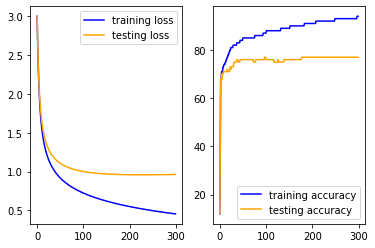

for training data, the final classification accuracy = 0.9362, and loss = 0.45469
for testing  data, the final classification accuracy = 0.76953, and loss = 0.96267


In [13]:
epoch = 300
learning_rate = 1e-4
# use batch gradient as optimizer
Batch_GD = Logistic_Regression(x_train_emnist, y_train_emnist, x_test_emnist, y_test_emnist, 8, learning_rate)
Batch_GD.Training(epoch, 'Batch GD')

For SGD :


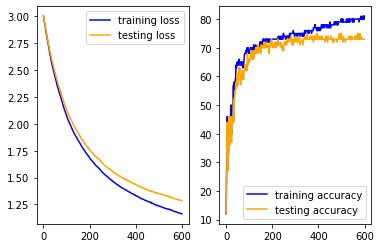

for training data, the final classification accuracy = 0.8099, and loss = 1.1624
for testing  data, the final classification accuracy = 0.73047, and loss = 1.28429


In [14]:
# use stochastic gradient (with 32 iteration each eopch) as optimizer
epoch = 600
SGD = Logistic_Regression(x_train_emnist, y_train_emnist, x_test_emnist, y_test_emnist, 8, learning_rate)
SGD.Training(epoch, 'SGD')

For Minibatch SGD :


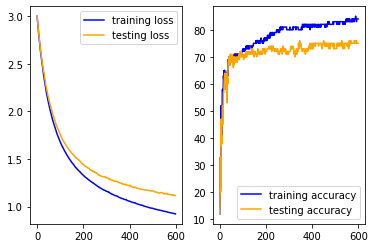

for training data, the final classification accuracy = 0.83594, and loss = 0.92317
for testing  data, the final classification accuracy = 0.75391, and loss = 1.11589


In [15]:
# use minibatch stochastic gradient as optimizer
Minibatch_SGD = Logistic_Regression(x_train_emnist, y_train_emnist, x_test_emnist, y_test_emnist, 8, learning_rate)
Minibatch_SGD.Training(epoch, 'Minibatch SGD', minibatch=64)

In [16]:
# for SVM
from sklearn.decomposition import PCA # transform the dimestion to 2D data
from matplotlib.colors import ListedColormap
from sklearn import svm
from sklearn.metrics import accuracy_score

In [17]:
# define kernel function for sklearn.svm.SVC
def Linear_kernel(x, y):
  return np.dot(x, y.T)

In [26]:
class SVM():
  def __init__(self, x, y, classes):
    self.classes = classes

    # dimension reduction
    pca = PCA(n_components=2)
    pca.fit(x)
    self.x = pca.transform(x)
    self.N = self.x.shape[0]

    # y need not be one-hot encoding
    self.Inverse_one_hot(y)
  
  # convert one-hot encoding to 1D
  def Inverse_one_hot(self, y):
    label = np.argmax(y, axis=1)
    self.y = np.array(label)

  # one-versus-the-rest
  def OvR(self, target_type):
    x1 = [self.x[c,:] for c in range(self.N) if self.y[c] == target_type]
    x2 = [self.x[c,:] for c in range(self.N) if self.y[c] != target_type]
    x = x1 + x2
    x = np.array(x)
    
    y1 = [1 for c in range(self.N) if self.y[c] == target_type]
    y2 = [-1 for c in range(self.N) if self.y[c] != target_type]
    y = y1 + y2
    y = np.array(y)
    
    return x, y

  # calculate w & b throught SVM
  def SVM_Process(self, x_train, y_train, target_type):
    # perform svm to get support vectors and Lagrange multipliers
    linear_svm = svm.SVC(kernel=Linear_kernel)
    linear_svm.fit(x_train, y_train)
    
    # get index of support vectors
    sv_index = linear_svm.support_

    # get the Lagrange multiplier (already multiply tn)
    alpha = np.abs(linear_svm.dual_coef_)
    
    # get support vector
    sv = [x_train[c,:] for c in range(x_train.shape[0]) if c in sv_index]
    sv = np.array(sv)
    
    # get the target value of support vectors
    t = [y_train[c] for c in range(y_train.shape[0]) if c in sv_index]
    t = np.array(t).reshape((1, -1))

    # target value reweighted
    alpha = alpha / t
    for i in range(t.shape[1]):
        if t[0,i] < 0:
            t[0,i] = -0.5
    alpha = alpha * t
    
    # calculate w
    w = np.dot(alpha, sv) # 1 x classes

    # calculate b
    b = 0
    for i, x1 in enumerate(sv):
        b += t[0,i]
        for j, x2 in enumerate(sv):
            b = b - alpha[0,j] * Linear_kernel(x1, x2)
    b = b / len(sv_index)
    
    sv_index = sv_index.tolist()
    
    return w, b
  
  # define voting criterion
  def Vote(self, x):
    # calculate score by w*x+b
    prediction = np.dot(x, self.w.T) + self.b
    vote = np.array(prediction)

    # choose the one that has the largest score
    label = np.argmax(vote, axis=1)

    return label

  # plot the geometry presentation
  def Plot(self, class_label):
    # define color for different classes
    colors = ['pink', 'wheat', 'red', 'yellow', 'lightgreen', 'lightblue', 'blue', 'purple', 'violet', 'silver']
    colors_dict = {0:'red', 1:'orange', 2:'darkred', 3:'gold', 4:'green', 5:'deepskyblue', 6:'navy', 7:'darkmagenta', 8:'darkviolet', 9:'dimgray'}
    my_map = ListedColormap(colors)
    
    # plot block color
    resolution = 100
    x1_range = np.linspace(np.min(self.x[:,0]), np.max(self.x[:,0]), resolution)
    x2_range = np.linspace(np.min(self.x[:,1]), np.max(self.x[:,1]), resolution)

    # use meshgrid to plot region color
    x1, x2 = np.meshgrid(x1_range, x2_range)

    # determine region color
    y_plot = []
    for i in x1_range:
      for j in x2_range:
        t = np.array([i, j]).reshape((1, 2))
        temp = self.Vote(t)
        y_plot.append(temp)
    
    y_plot = np.array(y_plot).reshape((x1.shape))
    # plot boundary
    plt.contourf(x1, x2, y_plot.T, cmap=my_map)
    
    # find support vectors
    linear_svm = svm.SVC(kernel=Linear_kernel)
    linear_svm.fit(self.x, self.y)
    sv = linear_svm.support_
    
    # plot the result
    p1, p2, p3, p4, p5, p6, p7, p8, p9, p10 = None, None, None, None, None, None, None, None, None, None
    for i in range(self.N):
        class_type = int(self.label[i])
        if i in sv:
            pp = plt.scatter(self.x[i, 0], self.x[i, 1], marker='o', color=colors_dict[class_type], edgecolors='black')
        elif class_type == 0:
            p1 = plt.scatter(self.x[i, 0], self.x[i, 1], marker='x', color=colors_dict[0])
        elif class_type == 1:
            p2 = plt.scatter(self.x[i, 0], self.x[i, 1], marker='x', color=colors_dict[1])
        elif class_type == 2:
            p3 = plt.scatter(self.x[i, 0], self.x[i, 1], marker='x', color=colors_dict[2])
        elif class_type == 3:
            p4 = plt.scatter(self.x[i, 0], self.x[i, 1], marker='x', color=colors_dict[3])
        elif class_type == 4:
            p5 = plt.scatter(self.x[i, 0], self.x[i, 1], marker='x', color=colors_dict[4])
        elif class_type == 5:
            p6 = plt.scatter(self.x[i, 0], self.x[i, 1], marker='x', color=colors_dict[5])
        elif class_type == 6:
            p7 = plt.scatter(self.x[i, 0], self.x[i, 1], marker='x', color=colors_dict[6])
        elif class_type == 7:
            p8 = plt.scatter(self.x[i, 0], self.x[i, 1], marker='x', color=colors_dict[7])
        elif class_type == 8:
            p9 = plt.scatter(self.x[i, 0], self.x[i, 1], marker='x', color=colors_dict[8])
        elif class_type == 9:
            p10 = plt.scatter(self.x[i, 0], self.x[i, 1], marker='x', color=colors_dict[9])
        
    # construct the list for lenged
    p1 = plt.scatter(np.NaN, np.NaN, marker='x', color=colors_dict[0])
    p2 = plt.scatter(np.NaN, np.NaN, marker='x', color=colors_dict[1])
    p3 = plt.scatter(np.NaN, np.NaN, marker='x', color=colors_dict[2])
    p4 = plt.scatter(np.NaN, np.NaN, marker='x', color=colors_dict[3])
    p5 = plt.scatter(np.NaN, np.NaN, marker='x', color=colors_dict[4])
    p6 = plt.scatter(np.NaN, np.NaN, marker='x', color=colors_dict[5])
    p7 = plt.scatter(np.NaN, np.NaN, marker='x', color=colors_dict[6])
    p8 = plt.scatter(np.NaN, np.NaN, marker='x', color=colors_dict[7])
    p9 = plt.scatter(np.NaN, np.NaN, marker='x', color=colors_dict[8])
    p10 = plt.scatter(np.NaN, np.NaN, marker='x', color=colors_dict[9])
    # plot the first cv again to let the label right
    pp = plt.scatter(self.x[sv[0], 0], self.x[sv[0], 1], marker='o', facecolors='None', color='black')
    
    if self.classes == 2:
      plt.legend([p1, p2, pp], class_label, loc='upper left')
    if self.classes == 8:
      plt.legend([p1, p2, p3, p4, p5, p6, p7, p8, pp], class_label, loc='upper left')
    elif self.classes == 10:
      plt.legend([p1, p2, p3, p4, p5, p6, p7, p8, p9, pp], class_label, loc='upper left')
    
    plt.title('linear SVM')
    plt.show()
  
  def Truth(self, class_label):
    # define color for different classes#    colors = ['pink', 'wheat', 'red', 'yellow', 'lightgreen', 'lightblue', 'blue', 'purple', 'violet', 'silver']
    colors_dict = {0:'red', 1:'orange', 2:'darkred', 3:'gold', 4:'green', 5:'deepskyblue', 6:'navy', 7:'darkmagenta', 8:'darkviolet', 9:'dimgray'}
    my_map = ListedColormap(colors)
    
    # plot block color
    resolution = 100
    x1_range = np.linspace(np.min(self.x[:,0]), np.max(self.x[:,0]), resolution)
    x2_range = np.linspace(np.min(self.x[:,1]), np.max(self.x[:,1]), resolution)

    # use meshgrid to plot region color
    x1, x2 = np.meshgrid(x1_range, x2_range)

    # determine region color
    y_plot = []
    for i in x1_range:
      for j in x2_range:
        t = np.array([i, j]).reshape((1, 2))
        temp = self.Vote(t)
        y_plot.append(temp)
    
    y_plot = np.array(y_plot).reshape((x1.shape))
    # plot boundary
    plt.contourf(x1, x2, y_plot.T, cmap=my_map)
    
    # find support vectors
    linear_svm = svm.SVC(kernel=Linear_kernel)
    linear_svm.fit(self.x, self.y)
    sv = linear_svm.support_
    
    # plot the result
    p1, p2, p3, p4, p5, p6, p7, p8, p9, p10 = None, None, None, None, None, None, None, None, None, None
    for i in range(self.N):
        class_type = int(self.y[i])
        if i in sv:
            pp = plt.scatter(self.x[i, 0], self.x[i, 1], marker='o', color=colors_dict[class_type], edgecolors='black')
        elif class_type == 0:
            p1 = plt.scatter(self.x[i, 0], self.x[i, 1], marker='x', color=colors_dict[0])
        elif class_type == 1:
            p2 = plt.scatter(self.x[i, 0], self.x[i, 1], marker='x', color=colors_dict[1])
        elif class_type == 2:
            p3 = plt.scatter(self.x[i, 0], self.x[i, 1], marker='x', color=colors_dict[2])
        elif class_type == 3:
            p4 = plt.scatter(self.x[i, 0], self.x[i, 1], marker='x', color=colors_dict[3])
        elif class_type == 4:
            p5 = plt.scatter(self.x[i, 0], self.x[i, 1], marker='x', color=colors_dict[4])
        elif class_type == 5:
            p6 = plt.scatter(self.x[i, 0], self.x[i, 1], marker='x', color=colors_dict[5])
        elif class_type == 6:
            p7 = plt.scatter(self.x[i, 0], self.x[i, 1], marker='x', color=colors_dict[6])
        elif class_type == 7:
            p8 = plt.scatter(self.x[i, 0], self.x[i, 1], marker='x', color=colors_dict[7])
        elif class_type == 8:
            p9 = plt.scatter(self.x[i, 0], self.x[i, 1], marker='x', color=colors_dict[8])
        elif class_type == 9:
            p10 = plt.scatter(self.x[i, 0], self.x[i, 1], marker='x', color=colors_dict[9])
        
    # construct the list for lenged
    p1 = plt.scatter(np.NaN, np.NaN, marker='x', color=colors_dict[0])
    p2 = plt.scatter(np.NaN, np.NaN, marker='x', color=colors_dict[1])
    p3 = plt.scatter(np.NaN, np.NaN, marker='x', color=colors_dict[2])
    p4 = plt.scatter(np.NaN, np.NaN, marker='x', color=colors_dict[3])
    p5 = plt.scatter(np.NaN, np.NaN, marker='x', color=colors_dict[4])
    p6 = plt.scatter(np.NaN, np.NaN, marker='x', color=colors_dict[5])
    p7 = plt.scatter(np.NaN, np.NaN, marker='x', color=colors_dict[6])
    p8 = plt.scatter(np.NaN, np.NaN, marker='x', color=colors_dict[7])
    p9 = plt.scatter(np.NaN, np.NaN, marker='x', color=colors_dict[8])
    p10 = plt.scatter(np.NaN, np.NaN, marker='x', color=colors_dict[9])
    # plot the first cv again to let the label right
    pp = plt.scatter(self.x[sv[0], 0], self.x[sv[0], 1], marker='o', facecolors='None', color='black')
    
    if self.classes == 2:
      plt.legend([p1, p2, pp], class_label, loc='upper left')
    if self.classes == 8:
      plt.legend([p1, p2, p3, p4, p5, p6, p7, p8, pp], class_label, loc='upper left')
    elif self.classes == 10:
      plt.legend([p1, p2, p3, p4, p5, p6, p7, p8, p9, pp], class_label, loc='upper left')
    
    plt.title('linear SVM')
    plt.show()

  # calculate predict accuracy
  def Precision(self):
    correct = [1 for i in range(self.N) if self.y[i] == self.label[i]]
    count = np.sum(correct)
    self.precision = count / self.N
    print('Presicion = '+str(round(self.precision, 2)))

  # main function of SVM
  def SVM(self):
    w, b = [], []

    # construct #(classes) SVM model
    for i in range(self.classes):
      # one-versus-the-rest
      x1, y1 = self.OvR(i)

      # perform svm to calculate w & b
      w1, b1 = self.SVM_Process(x1, y1, i)

      w.append(w1)
      b.append(b1)
    
    self.w = np.array(w).reshape(self.classes, 2)
    self.b = np.array(b)

    # predict the training data
    self.label = self.Vote(self.x)
    self.Precision()
  
  # use the sklearn package to perfrom SVM
  def SKLearn(self):
    linear_svm = svm.SVC(kernel='linear')
    linear_svm.fit(self.x, self.y)

    self.label = linear_svm.predict(self.x)
    self.w = linear_svm.coef_
    self.b = linear_svm.intercept_
    size = self.y.shape[0]
    print(accuracy_score(self.y.reshape((size, -1)), self.label.reshape((size, -1))))
    self.Precision()

In [27]:
emnist_svm = SVM(x_train_emnist, y_train_emnist, 8)
emnist_svm.SVM()

Presicion = 0.33


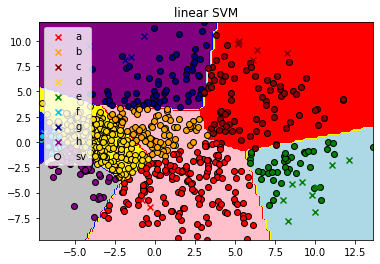

In [28]:
emnist_label = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'sv']
emnist_svm.Plot(emnist_label)

In [29]:
# for FCNN

In [50]:
class FCNN():
    def __init__(self, x, y, classes=2, minibatch=280, h1=20, h2=10):
        # data parameter
        self.x, self.y = x, y
        self.size = x.shape[0] # dataset size
        self.D = x.shape[1] # dataset features (dimension)
        self.classes = classes # number of classes
        self.minibatch = minibatch
        
        # hidden layer parameters
        self.h1, self.h2 = h1, h2 # number of hidden units in first and second hidden layers
        self.W0 = np.zeros((self.D, self.h1))
        self.W1 = np.zeros((self.h1, self.h2))
        self.Wout = np.zeros((self.h2, classes))
        
        self.b0 = np.zeros((1, h1))
        self.b1 = np.zeros((1, h2))
        self.bout = np.zeros((1, classes))
        
        # performance parameter
        self.eta = 0.0025
        self.label_class = np.argmax(self.y, axis=1)
        self.loss, self.precision = [], []
    
    # hidden layer operation
    def Hidden_layer(self, x, w, b):
        return np.dot(x, w) + b
    
    # activation function of hidden layer
    def Sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    # softmax function for output layer
    # z is the unnormalized probability
    def Softmax(self, z):
        exp_z = np.exp(z)
        exp_sum = np.sum(exp_z, axis=1).reshape(np.shape(exp_z)[0], 1)
        return exp_z / exp_sum
    
    # calculate cross-entropy loss and save it during training
    def Cross_entropy(self):  # y have pass through softmax function
        E = 0
        q = np.log2(self.y_pred.T)
        for i in range(self.size):
            E -= self.y[i][0] * q[0][i] + self.y[i][1] * q[1][i]
        self.loss.append(E)
    
    # calculate the classification accuracy
    def Precision(self):
        # convert one-hot to classes
        y_pred_class = np.argmax(self.y_pred, axis=1)
        count = 0
        for i in range(self.size):
            if y_pred_class[i] == self.label_class[i]:
                count += 1
        self.precision.append(count / self.size)
    
    # gradient of (softmax + cross-entropy) loss
    def Softmax_CrossEntropy_Derivative(self, y_pred, y):
        return y_pred - y
    
    # activation function derivative
    def Sigmoid_Derivative(self, x):
        return self.Sigmoid(x) * (1 - self.Sigmoid(x))
    
    # weight derivative
    def Weight_Gradient(self, a, y):
        return np.dot(a.T, y)
    
    # bias derivative
    def Bias_Gradient(self, y):
        return np.sum(y, axis=0)
    
    # forward-propagation
    def Forward(self):
        # first hidden layer
        self.a0 = self.Hidden_layer(self.x, self.W0, self.b0)
        self.y0 = self.Sigmoid(self.a0)
        
        # second hidden layer
        self.a1 = self.Hidden_layer(self.y0, self.W1, self.b1)
        self.y1 = self.Sigmoid(self.a1)
        
        # output layer
        self.aout = self.Hidden_layer(self.y1, self.Wout, self.bout)
        self.y_pred = self.Softmax(self.aout)
        
        self.Cross_entropy()
        self.Precision()
    
    def Derivative_sigmoid(self, x):
        return self.Sigmoid(x) * (1-self.Sigmoid(x))
    
    # backward-propagation
    def Backward(self):
        # create minibatch data
        sgd_x = np.zeros((self.minibatch, self.D))
        sgd_a0 = np.zeros((self.minibatch, self.h1))
        sgd_y0 = np.zeros((self.minibatch, self.h1))
        sgd_a1 = np.zeros((self.minibatch, self.h2))
        sgd_y1 = np.zeros((self.minibatch, self.h2))
        sgd_y_pred = np.zeros((self.minibatch, self.classes))
        sgd_y = np.zeros((self.minibatch, self.classes))
        
        # randomly choose minibatch data to update gradient
        rand_index = np.random.choice(self.size, self.minibatch, replace=False)
        
        for i in range(len(rand_index)):
            sgd_x[i, :] = self.x[rand_index[i], :]
            sgd_a0[i, :] = self.a0[rand_index[i], :]
            sgd_y0[i, :] = self.y0[rand_index[i], :]
            sgd_a1[i, :] = self.a1[rand_index[i], :]
            sgd_y1[i, :] = self.y1[rand_index[i], :]
            sgd_y_pred[i, :] = self.y_pred[rand_index[i], :]
            sgd_y[i, :] = self.y[rand_index[i], :]

        # calculate gradient for each parameter
        grad_y_pred = sgd_y_pred - sgd_y  # minibatch * 2
        grad_wout = np.dot(sgd_y1.T, grad_y_pred)  # H2 * 2
        grad_bout = np.sum(grad_y_pred, axis=0)  # 1 * 2

        grad_y1 = np.dot(grad_y_pred, self.Wout.T) * self.Derivative_sigmoid(sgd_a1) # minibatch * H2
        grad_w1 = np.dot(sgd_y0.T, grad_y1)  # H1 * H2
        grad_b1 = np.sum(grad_y1, axis=0)  # 1* H2

        grad_y0 = np.dot(grad_y1, self.W1.T) * self.Derivative_sigmoid(sgd_a0) # minibatch * H
        grad_w0 = np.dot(sgd_x.T, grad_y0)  # D * H1
        grad_b0 = np.sum(grad_y0, axis=0)  # 1* H1
    
        # update weights and bias
        self.W0 -= grad_w0 * self.eta
        self.b0 -= grad_b0 * self.eta
        
        self.W1 -= grad_w1 * self.eta
        self.b1 -= grad_b1 * self.eta
        
        self.Wout -= grad_wout * self.eta
        self.bout -= grad_bout * self.eta
    
    # plot learning curve
    def Plot(self):
        x_axis = list(range(self.epoch))
        
        # plot learning curve
        plt.subplot(1, 2, 1)
        plt.plot(x_axis, self.loss, color='blue', label='training loss')
        plt.legend()
        
        # plot precision curve
        plt.subplot(1, 2, 2)
        percetage = [round(i, 2)*100 for i in self.precision]
        plt.plot(x_axis, percetage, color='blue', label='training accuracy')
        plt.legend()

        plt.show()
    
    # output final loss and accuracy
    def Final_Result(self):
        print('Final training   loss   = ' + str(self.loss[self.epoch-1]))
        percentage = round(self.precision[self.epoch-1], 4) * 100
        print('Final training accuracy = ' + str(percentage) + ' %')
    
    # training main function
    def Training(self, epoch):
        self.epoch = epoch
        self.count = 0
        # training
        for i in range(self.epoch):
            self.count += 1
            self.Forward()
            self.Backward()
        
        # plot loss and accuracy
        self.Plot()
        self.Final_Result()

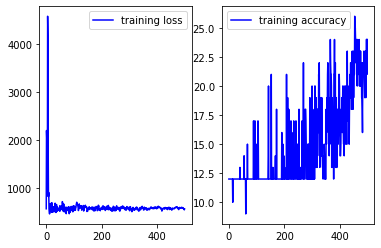

Final training   loss   = 573.8463543100697
Final training accuracy = 23.7 %


In [52]:
fcnn_emnist = FCNN(x_train_emnist, y_train_emnist, classes=8, minibatch=64, h1=1024, h2=2048)
fcnn_emnist.Training(epoch=500)

In [31]:
# for CNN
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import random

from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [32]:
class EMNIST_CNN():
  def __init__(self, x, y):
    self.x_train, self.y_train, self.x_valid, self.y_valid = self.Split_Dataset(x, y)
    self.model = self.EMNIST_Model()
  
  # splid data into training and validation set
  def Split_Dataset(self, x, y):
    # random shuffle
    index = np.arange(x.shape[0]) # create an integer list from 0 ~ t_len
    np.random.shuffle(index)
    x = x[index]
    y = y[index]

    # seperate temp set to training and validation set
    total_length = x.shape[0]
    training_length = int(x.shape[0]*0.9)
    x_train = x[:training_length]
    y_train = y[:training_length]
    x_valid = x[training_length:total_length]
    y_valid = y[training_length:total_length]

    return x_train, y_train, x_valid, y_valid

  # construct CNN model for EMNIST
  def EMNIST_Model(self, output_size=8):
      # model construction
      model = Sequential()

      # first layer (conv)
      model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
      model.add(MaxPooling2D(pool_size = (2,2)))

      # second layer (conv)
      model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
      model.add(MaxPooling2D(pool_size = (2,2)))
      model.add(Flatten())
      
      # third layer (fully)
      model.add(Dense(64, activation='relu'))
      model.add(Dropout(0.5))

      # output layer (fully)
      model.add(Dense(output_size, activation='softmax'))
      
      # compile model
      model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
      
      return model
  
  # training process
  def Training(self, epoch=50):
    self.history = self.model.fit(self.x_train, self.y_train, epochs=epoch, batch_size=32, validation_data=(self.x_valid, self.y_valid))

  # plot learning information
  def Plot(self):
    # plot learning curve
    plt.plot(self.history.history['loss'], color='blue', label='training loss')
    plt.title('Learning Curve')
    plt.xlabel('epochs')
    plt.ylabel('cross-entropy loss')
    plt.legend()
    plt.show()

    plt.plot(self.history.history['accuracy'], color='blue', label='training accuracy')
    plt.plot(self.history.history['val_accuracy'], color='red', label='validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy rate')
    plt.legend()
    plt.show()

In [33]:
emnist_cnn = EMNIST_CNN(x_train_2d_emnist, y_train_2d_emnist)
emnist_cnn.Training()

Epoch 1/50
22/22 [==============================] - 16s 20ms/step - loss: 1.9263 - accuracy: 0.2648 - val_loss: 1.6139 - val_accuracy: 0.5195
Epoch 2/50
22/22 [==============================] - 0s 6ms/step - loss: 1.4508 - accuracy: 0.5080 - val_loss: 1.2747 - val_accuracy: 0.5455
Epoch 3/50
22/22 [==============================] - 0s 7ms/step - loss: 1.1802 - accuracy: 0.5774 - val_loss: 0.9574 - val_accuracy: 0.6364
Epoch 4/50
22/22 [==============================] - 0s 6ms/step - loss: 1.0165 - accuracy: 0.6585 - val_loss: 0.7748 - val_accuracy: 0.7143
Epoch 5/50
22/22 [==============================] - 0s 6ms/step - loss: 0.8489 - accuracy: 0.7120 - val_loss: 0.7747 - val_accuracy: 0.7273
Epoch 6/50
22/22 [==============================] - 0s 6ms/step - loss: 0.7987 - accuracy: 0.7308 - val_loss: 0.6702 - val_accuracy: 0.7662
Epoch 7/50
22/22 [==============================] - 0s 7ms/step - loss: 0.6891 - accuracy: 0.7656 - val_loss: 0.6707 - val_accuracy: 0.7662
Epoch 8/50
22/22 [

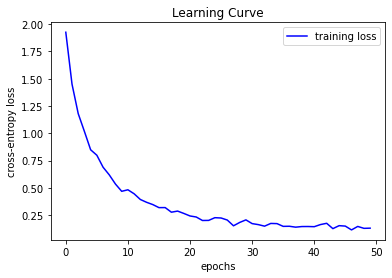

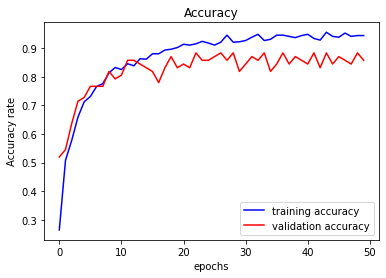

In [34]:
emnist_cnn.Plot()

In [35]:
# The following parts are about CIFAR-10 dataset

In [36]:
# load data from the specified dataset in Keras
def Load_Keras_Dataset(dataset, dimension, size=32, channel=3):
    (x_train, y_train), (x_test, y_test) = dataset.load_data()
    # normalize (preprocessing)
    x_train = x_train / 255.0
    x_test = x_test / 255.0

    # random shuffle training data
    index = np.arange(x_train.shape[0]) # create an integer list from 0 ~ total
    np.random.shuffle(index)
    x_train = np.array([x_train[i] for i in index])
    y_train = np.array([y_train[i] for i in index])
    
    # if not applying CNN, then flatten input image to 1D array
    if dimension == 1:
        x_train_flatten, x_test_flatten = [], []
        for i in range(x_train.shape[0]):
            x_train_flatten.append(x_train[i].flatten())
        x_train = np.array(x_train_flatten)
        for i in range(x_test.shape[0]):
            x_test_flatten.append(x_test[i].flatten())
        x_test = np.array(x_test_flatten)
    elif dimension == 2:
      x_train = x_train.reshape((x_train.shape[0], size, size, channel))
      x_test = x_test.reshape((x_test.shape[0], size, size, channel))

    # one-hot encoding
    y_original = np.copy(y_train)
    classes = 10
    y_train = One_hot_encoding(y_train, classes)
    y_test = One_hot_encoding(y_test, classes)

    # extract corresponding target for svm
    x1 = [x_train[i,:] for i in range(x_train.shape[0]) if y_original[i] == 1]
    x2 = [x_train[i,:] for i in range(x_train.shape[0]) if y_original[i] == 2]
    x_svm = np.array(x1 + x2)
    y1 = [y_train[i,:] for i in range(x_train.shape[0]) if y_original[i] == 1]
    y2 = [y_train[i,:] for i in range(x_train.shape[0]) if y_original[i] == 2]
    y_svm = np.array(y1 + y2)

    # random shuffle svm and take 1000 data only
    index = np.random.choice(range(x_svm.shape[0]), 1000, replace=False)
    x_svm_cifar = np.array([x_svm[c,:] for c in index])
    y_svm_cifar = np.array([y_svm[c,:] for c in index])

    #return x_train, y_train, x_test, y_test, x_svm_cifar[:1000], y_svm_cifar[:1000]
    return x_train, y_train, x_test, y_test, x_train[:10000], y_train[:10000]

In [37]:
x_train_cifar, y_train_cifar, x_test_cifar, y_test_cifar, x_small_cifar, y_small_cifar = Load_Keras_Dataset(tf.keras.datasets.cifar10, 1)
x_train_cifar2d, y_train_cifar2d, x_test_cifar2d, y_test_cifar2d, s1, s2 = Load_Keras_Dataset(tf.keras.datasets.cifar10, 2)

170508288/170498071 [==============================] - 2s 0us/step


In [38]:
# Least square method

In [39]:
LS_train_cifar = LS(x_train_cifar, y_train_cifar, 'training')
LS_train_cifar.LS_Method()
LS_W_cifar = LS_train_cifar.Get_Weight()

LS_test_cifar = LS(x_test_cifar, y_test_cifar, '  test  ')
LS_test_cifar.Training_Weight(LS_W_cifar)
LS_test_cifar.LS_Method()

For training data : 
	The classification accuarcy = 50.94%
	The classification loss     = 0.3647
For   test   data : 
	The classification accuarcy = 36.370000000000005%
	The classification loss     = 0.4166


In [53]:
# logistic regression

For Minibatch SGD :


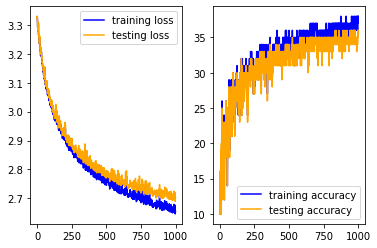

for training data, the final classification accuracy = 0.3791, and loss = 2.65441
for testing  data, the final classification accuracy = 0.3565, and loss = 2.70256


In [54]:
# use minibatch stochastic gradient as optimizer
epoch = 1000
eta_cifar = 8e-5
Minibatch_SGD_cifar = Logistic_Regression(x_small_cifar, y_small_cifar, x_test_cifar, y_test_cifar, 10, eta_cifar)
Minibatch_SGD_cifar.Training(epoch, 'Minibatch SGD', minibatch=64)

In [55]:
# SVM

In [56]:
cifar_svm = SVM(x_small_cifar, y_small_cifar, 10)
cifar_svm.SVM()

Presicion = 0.2


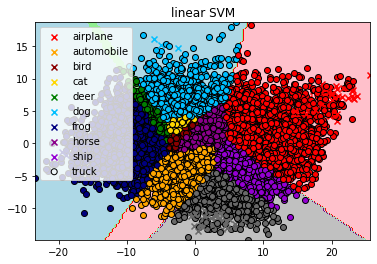

In [59]:
cifar_label = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'sv']
cifar_svm.Plot(cifar_label)

In [60]:
# FCNN

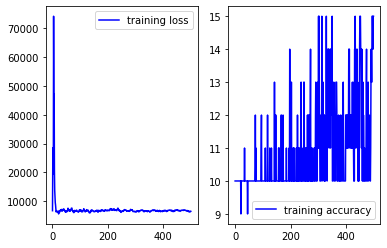

Final training   loss   = 6524.5038767268425
Final training accuracy = 14.91 %


In [61]:
fcnn_cifar = FCNN(x_small_cifar, y_small_cifar, classes=10, minibatch=64, h1=1024, h2=2048)
fcnn_cifar.Training(epoch=500)

In [62]:
# CNN

In [63]:
class CIFAR_CNN():
  def __init__(self, x, y):
    self.x_train, self.y_train, self.x_valid, self.y_valid = self.Split_Dataset(x, y)
    self.model = self.CIFAR_Model()
  
  # splid data into training and validation set
  def Split_Dataset(self, x, y):
    # random shuffle
    index = np.arange(x.shape[0]) # create an integer list from 0 ~ t_len
    np.random.shuffle(index)
    x = x[index]
    y = y[index]

    # seperate temp set to training and validation set
    total_length = x.shape[0]
    training_length = int(x.shape[0]*0.9)
    x_train = x[:training_length]
    y_train = y[:training_length]
    x_valid = x[training_length:total_length]
    y_valid = y[training_length:total_length]

    return x_train, y_train, x_valid, y_valid

  # construct CNN model for CIFAR-10
  def CIFAR_Model(self, output_size=10):
    # model construction
    model = Sequential()

    # first layer (conv), input_shape=(32, 32, 3)
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))

    # second layer (conv)
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    # third layer (conv)
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Flatten())
    
    # fourth layer (fully)
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    # output layer (fully)
    model.add(Dense(output_size, activation='softmax'))
    
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
  
  # training process
  def Training(self, epoch=50):
    self.history = self.model.fit(self.x_train, self.y_train, epochs=epoch, batch_size=32, validation_data=(self.x_valid, self.y_valid))

  # plot learning information
  def Plot(self):
    # plot learning curve
    plt.plot(self.history.history['loss'], color='blue', label='training loss')
    plt.title('Learning Curve')
    plt.xlabel('epochs')
    plt.ylabel('cross-entropy loss')
    plt.legend()
    plt.show()

    plt.plot(self.history.history['accuracy'], color='blue', label='training accuracy')
    plt.plot(self.history.history['val_accuracy'], color='red', label='validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy rate')
    plt.legend()
    plt.show()

In [64]:
cifar_cnn = CIFAR_CNN(x_train_cifar2d, y_train_cifar2d)
cifar_cnn.Training()

Epoch 1/50
1407/1407 [==============================] - 14s 9ms/step - loss: 1.5615 - accuracy: 0.4241 - val_loss: 1.1398 - val_accuracy: 0.5934
Epoch 2/50
1407/1407 [==============================] - 12s 9ms/step - loss: 1.0498 - accuracy: 0.6263 - val_loss: 0.9078 - val_accuracy: 0.6722
Epoch 3/50
1407/1407 [==============================] - 12s 9ms/step - loss: 0.8321 - accuracy: 0.7073 - val_loss: 0.8695 - val_accuracy: 0.7014
Epoch 4/50
1407/1407 [==============================] - 12s 8ms/step - loss: 0.7009 - accuracy: 0.7528 - val_loss: 0.7488 - val_accuracy: 0.7418
Epoch 5/50
1407/1407 [==============================] - 12s 8ms/step - loss: 0.6011 - accuracy: 0.7880 - val_loss: 0.7045 - val_accuracy: 0.7602
Epoch 6/50
1407/1407 [==============================] - 12s 9ms/step - loss: 0.5158 - accuracy: 0.8183 - val_loss: 0.7272 - val_accuracy: 0.7634
Epoch 7/50
1407/1407 [==============================] - 12s 9ms/step - loss: 0.4532 - accuracy: 0.8376 - val_loss: 0.7093 - val_ac

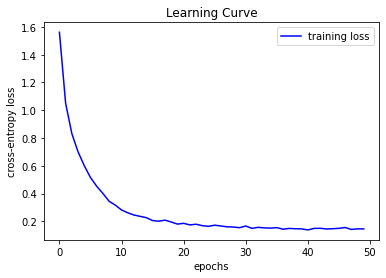

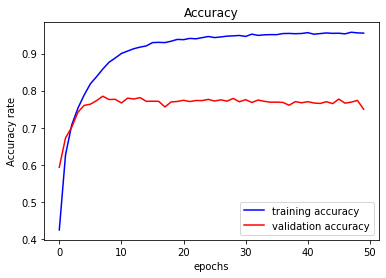

In [65]:
cifar_cnn.Plot()